In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Concatenate, Conv2D, Input, MaxPooling2D, Conv2DTranspose, Cropping2D, Add, Activation
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import shutil
import os

58892288/58889256 [==============================] - 0s 0us/step


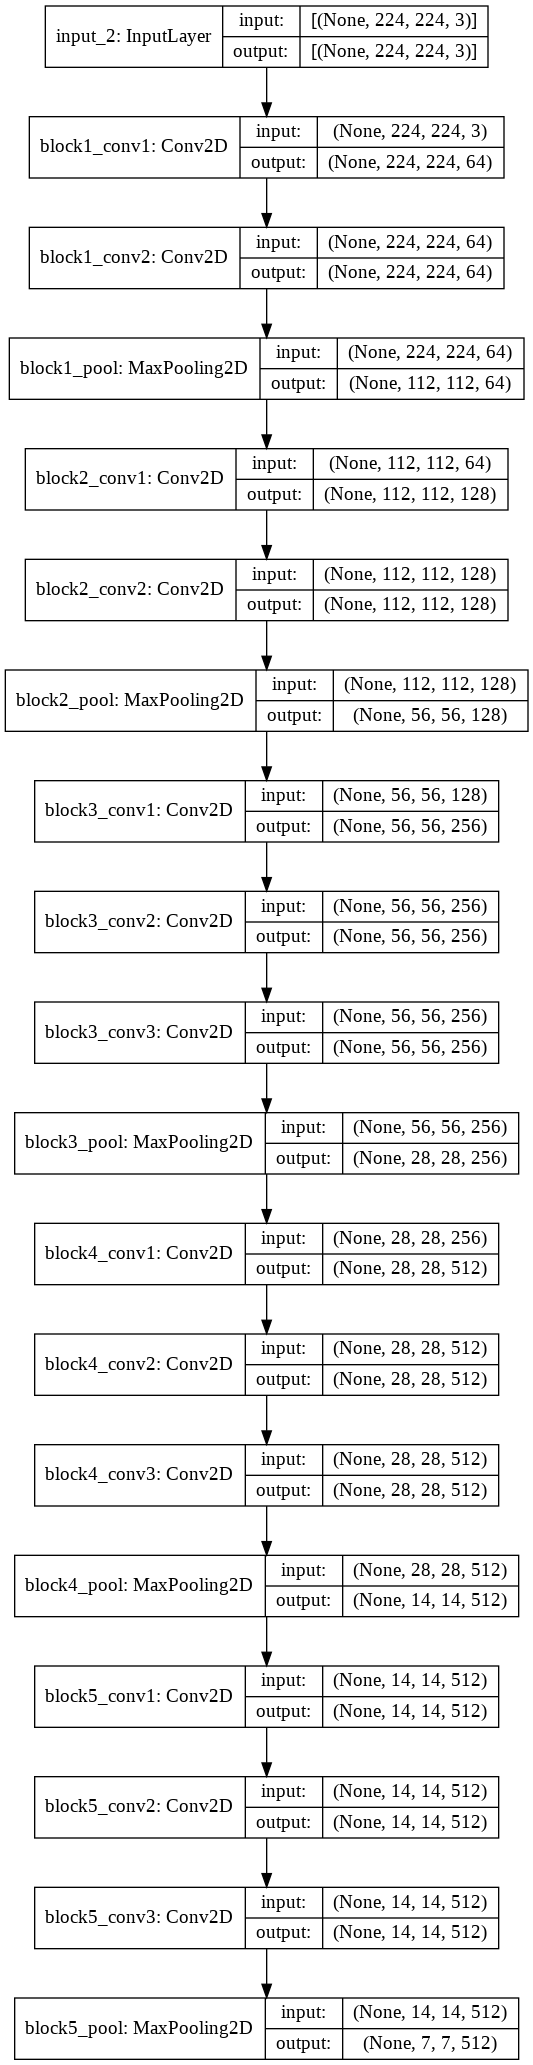

In [ ]:
model2 = tf.keras.applications.VGG16(include_top=False,input_shape=(224, 224, 3))
plot_model(model2, show_shapes=True)

In [ ]:
weights = []
for l in model2.layers:
  # print(l.get_weights())
  if len(l.weights) != 0:
    weights.append(l.weights)

In [ ]:
def Unet(nClass = 12, inputShape = (128, 128, 3)):
  def convBlockEncoder(x, filter):
    for i in range(2):
      x = Conv2D(filter, 3, activation='relu', padding='same')(x)
    y = x
    x = MaxPooling2D()(x)
    return x, y
  
  filters = [64, 128, 256, 512]
  x = Input(inputShape)
  inp = x
  skip = []
  for i in range(4):
    x, y = convBlockEncoder(x, filters[i])
    skip.append(y)
  
  x = Conv2D(1024, 3, activation='relu', padding='same')(x)
  x = Conv2D(512, 3, activation='relu', padding='same')(x)
  for i in range(4):
    x = Conv2DTranspose(filters[3 - i], 2, strides = 2)(x)
    x = Concatenate()([skip[3 - i], x])
    for j in range(2):
      x = Conv2D(filters[3 - i], 3, activation='relu', padding='same')(x)
  
  x = Conv2D(nClass, 1, activation='relu')(x)

  model = Model(inputs = inp, outputs = x)
  return model

model = Unet()
model.summary() 
plot_model(model, show_shapes = True)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 224, 224, 64) 1792        input_12[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 224, 224, 64) 36928       conv0[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D) (None, 112, 112, 64) 0           conv1[0][0]                      
____________________________________________________________________________________________

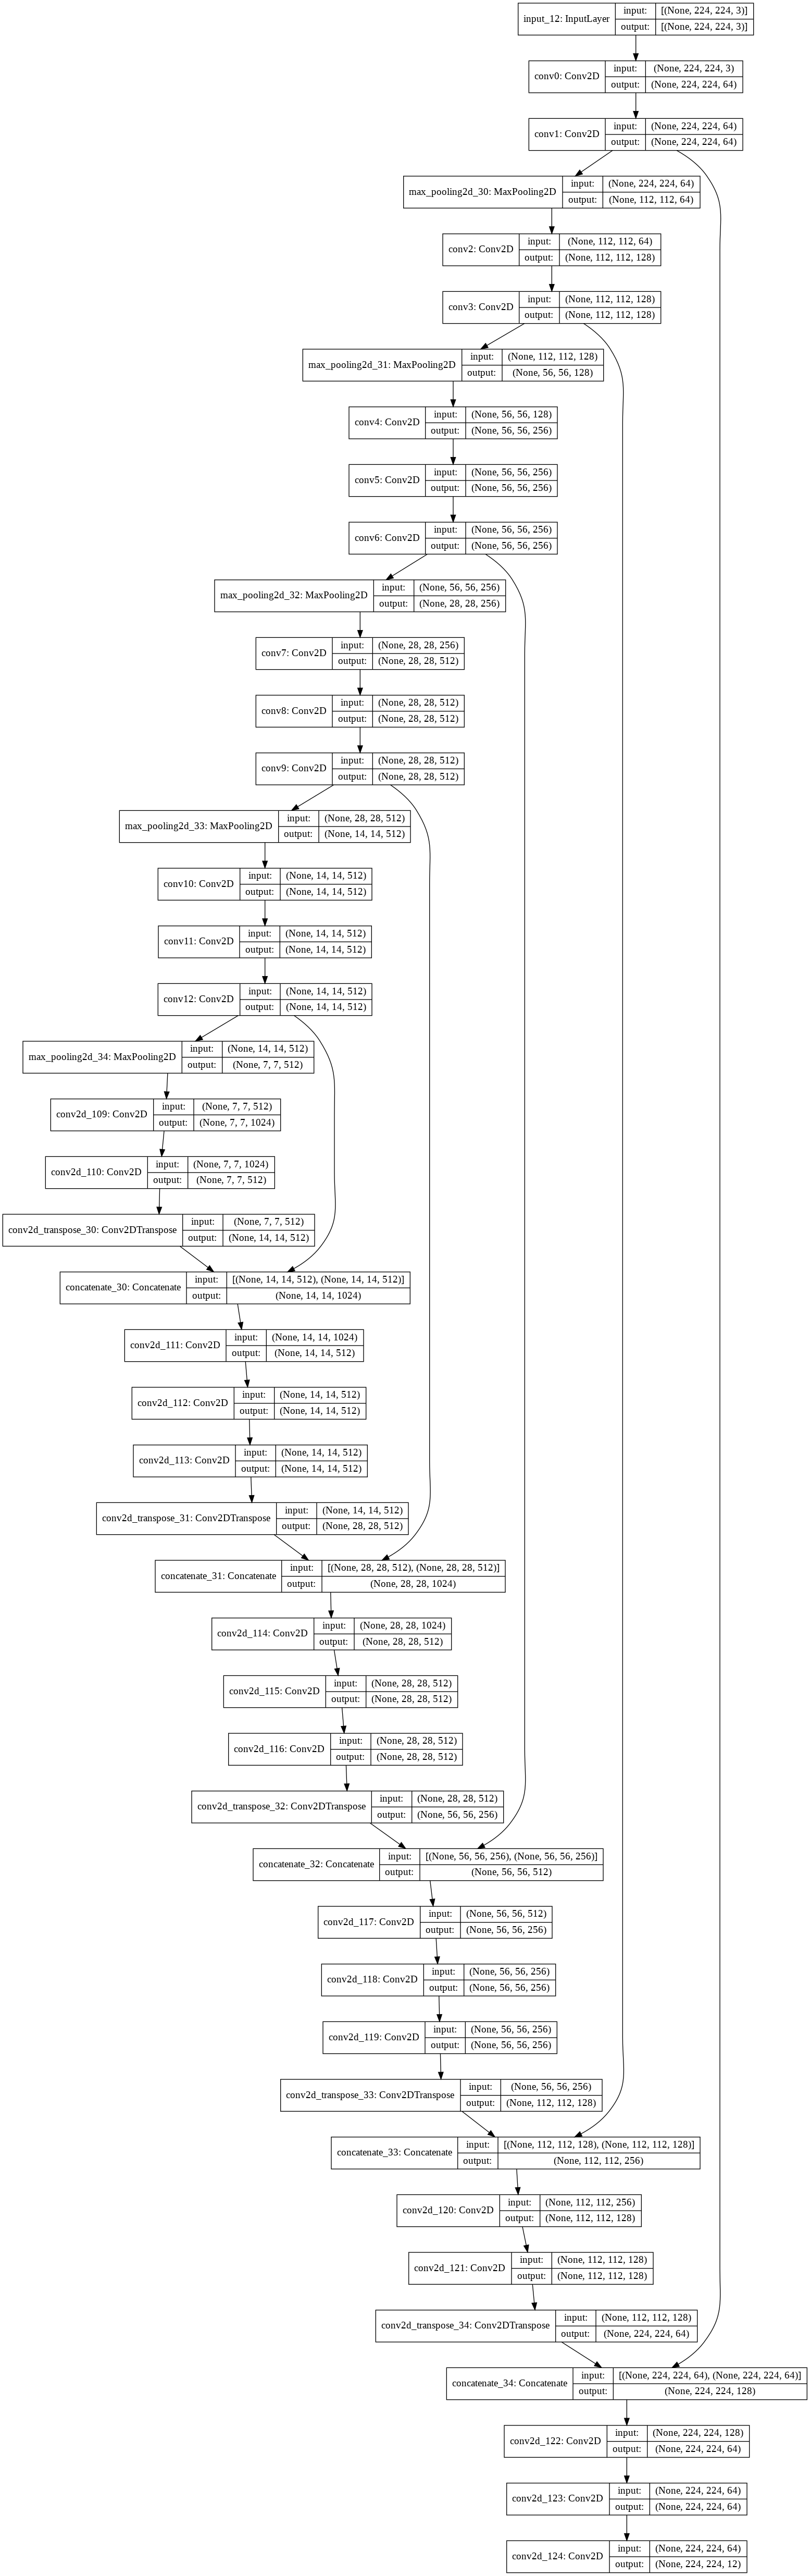

In [ ]:
def VGG16UNET(nClass = 12, inputShape = (224, 224, 3)):
  def convBlockEncoder(x, filter, n, index):
    for i in range(n):
      x = Conv2D(filter, 3, activation='relu', padding='same', name = 'conv' + str(index))(x)
      index +=  1
    y = x
    x = MaxPooling2D()(x)
    return x, y
  filters = [64, 128, 256, 512, 512]
  numberOfConvBlocks = [2, 2 , 3, 3 , 3]
  skip = []
  x = Input(inputShape)
  inp = x
  index = 0
  for i in range(5):
    x, y = convBlockEncoder(x, filters[i], numberOfConvBlocks[i], index)
    index += numberOfConvBlocks[i]
    skip.append(y)
  x = Conv2D(1024, 3, activation='relu', padding='same')(x)
  x = Conv2D(512, 3, activation='relu', padding='same')(x)
  for i in range(5):
    x = Conv2DTranspose(filters[4 - i], 2, strides = 2)(x)
    x = Concatenate()([skip[4 - i], x])
    for j in range(numberOfConvBlocks[4 - i]):
      x = Conv2D(filters[4 - i], 3, activation='relu', padding='same')(x)
  x = Conv2D(nClass, 1, activation='relu')(x)

  model = Model(inputs = inp, outputs = x)
  return model

model = VGG16UNET()
model.summary() 
plot_model(model, show_shapes = True)

In [ ]:
def convBlock(x, filters, numberOfConvBlocks, index):
  for i in range(numberOfConvBlocks):
    # print(x.shape)
    x = Conv2D(filters, 3, padding='same',activation='relu' , name = 'conv' + str(index))(x)
    index += 1

  x = MaxPooling2D()(x)
  return x

def convTranspose(x, filter, kernel, stride, crop = True):
  x = Conv2DTranspose(filter, kernel, stride)(x)
  if crop:
    x = Cropping2D((1,1))(x)
  return x

def VGG16(inputShape = (224,224,3), nClass = 10):
  inp = Input(inputShape)
  x = inp
  filters = [64, 128, 256, 512, 512]
  numberOfConvBlocks = [2, 2 , 3, 3 , 3]
  poolLayers = []
  index = 0
  for c, f in enumerate(filters):
    x = convBlock(x, f, numberOfConvBlocks[c], index)
    index += numberOfConvBlocks[c]
    poolLayers.append(x)
  
  prev = poolLayers[4]
  for i in range(2):
    firstPool = prev
    firstPool = convTranspose(firstPool, nClass, 4, 2)
    secondPool = poolLayers[4 - i - 1]
    secondPool = Conv2D(nClass, 1, 1, 'same', activation='relu')(secondPool)
    prev = Add()([firstPool , secondPool])

  prev = Conv2DTranspose(nClass, 8, 8)(prev)
  x = prev
  x = Activation('softmax')(x)
  model = Model(inputs = inp, outputs = x)
  return model

model = VGG16(nClass=12)
model.summary()
plot_model(model, show_shapes=True)

In [ ]:
! wget https://github.com/divamgupta/datasets/releases/download/seg/dataset1.zip && unzip dataset1.zip

In [ ]:
def createAndMoveToImages(path):
  os.mkdir(path + '/images')
  files = os.listdir(path)
  for f in files:
    shutil.move(path + '/' + f, path + '/images')

createAndMoveToImages('/content/dataset1/images_prepped_test')
createAndMoveToImages('/content/dataset1/images_prepped_train')


In [ ]:
INPUT_SHAPE = (224, 224)

In [ ]:
annotationPath = '/content/dataset1/annotations_prepped_train'
imagePath = '/content/dataset1/images_prepped_train/images'
aL = os.listdir(annotationPath)
iL = os.listdir(imagePath)

uniqueVals = {0}
for f in aL:
  arr = plt.imread(annotationPath + '/' + f)
  valList = list(np.unique(tf.image.resize(np.expand_dims(arr, axis = -1), size = INPUT_SHAPE,method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy()))
  for v in valList:
    uniqueVals.add(v)

values = list(uniqueVals)

In [ ]:
aL[0],iL[0], values

('0016E5_04530.png',
 '0016E5_04530.png',
 [0,
  0.003921569,
  0.015686275,
  0.007843138,
  0.011764706,
  0.019607844,
  0.023529412,
  0.03137255,
  0.03529412,
  0.039215688,
  0.043137256,
  0.02745098])

In [ ]:
trainDataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = '/content/dataset1/images_prepped_train',
    labels = sorted(os.listdir('/content/dataset1/images_prepped_train/images')),
    color_mode="rgb",
    batch_size=32,
    image_size=INPUT_SHAPE,
    shuffle=False
)
trainDataset = trainDataset.unbatch()
trainDataset

Found 367 files belonging to 1 classes.


<_UnbatchDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.string)>

In [ ]:
testDataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = '/content/dataset1/images_prepped_test',
    labels = sorted(os.listdir('/content/dataset1/images_prepped_test/images')),
    color_mode="rgb",
    batch_size=32,
    image_size=INPUT_SHAPE,
    shuffle=False
)
testDataset = testDataset.unbatch()
testDataset

Found 101 files belonging to 1 classes.


<_UnbatchDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.string)>

In [ ]:
annotation = tf.Variable(np.zeros(shape=(INPUT_SHAPE[0], INPUT_SHAPE[1], 1)), dtype=tf.uint8)
def mapFunc(path):
  def generateLabel(image, label):
    labelImage = tf.io.read_file(path + '/' + label)
    labelImage = tf.image.decode_png(labelImage, channels=1)
    labelImage = tf.image.resize(labelImage, size = INPUT_SHAPE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # tf.print(labelImage.shape)
    annotation[:, :, :].assign(labelImage)
    for index, v in enumerate(values):
      mask = tf.equal(annotation, v)
      annotation[:, :, :].assign(tf.where(mask,tf.cast(index, tf.uint8),annotation))
    image = image / 127.5
    image -= 1
    return image, annotation
  return generateLabel

mappedTrain = trainDataset.map(mapFunc(annotationPath))
mappedTest = testDataset.map(mapFunc('/content/dataset1/annotations_prepped_test'))

(224, 224, 1)


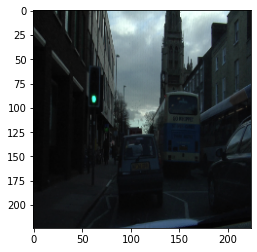

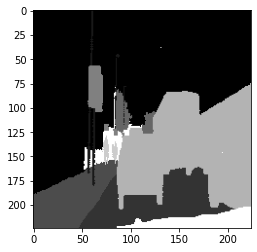

[ 1  2  3  4  5  6  8  9 11]
(224, 224, 1)


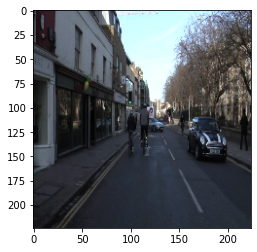

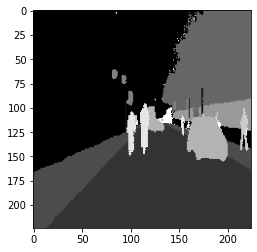

[ 1  2  3  4  5  6  7  8  9 10 11]


In [ ]:
for i in mappedTrain:
  print(i[1].shape)
  ts = i
  img = np.squeeze(i[0])
  img = img + 1
  img *= 127.5
  plt.imshow(img.astype('int'))
  plt.show()
  plt.imshow(np.squeeze(i[1]), cmap='gray')
  plt.show()
  print(np.unique(i[1]))
  break;
for i in mappedTest:
  print(i[1].shape)
  t = i
  img = np.squeeze(i[0])
  img = img + 1
  img *= 127.5

  plt.imshow(img.astype('int'))
  plt.show()
  plt.imshow(np.squeeze(i[1]), cmap='gray')
  plt.show()
  print(np.unique(i[1]))
  break;

In [ ]:
batchedTrain = mappedTrain.shuffle(1024).batch(32)
batchedTest = mappedTest.shuffle(1024).batch(32)
batchedTrain, batchedTest

(<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.uint8)>,
 <BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.uint8)>)

In [ ]:
for i, l in enumerate(weights):
  layer = model.get_layer(name = 'conv' + str(i))
  layer.set_weights([_.numpy() for _ in l])

In [ ]:
def IOU(nClass, smoothingFactor = .0000001):
  def IOU_(yTrue, yPred):
    yReduced = tf.math.argmax(yPred, axis = -1)
    yTrue = tf.squeeze(yTrue)
    classWiseIOU = []
    for i in range(nClass):
      a = tf.cast(( yTrue == i ), dtype=tf.float32)
      b = tf.cast(( yReduced == i ), dtype=tf.float32)
      intersection = tf.math.reduce_sum(a * b)
      a = tf.math.reduce_sum(a)
      b = tf.math.reduce_sum(b)
      iou = intersection / (a + b - intersection + smoothingFactor)
      classWiseIOU.append(iou)
    return classWiseIOU
  return IOU_

In [ ]:
var = tf.Variable([[2, 3], [2, 5]])
# tf.unique(var)
var = tf.reshape(var, shape = (-1,))
tf.unique(var)[0].shape
# for i in var:
#   print(i)
tf.math.reduce_sum(tf.cast(var == 2, dtype=tf.int32))
tf.math.argmax(var, axis = -1)

<tf.Tensor: shape=(), dtype=int64, numpy=3>

In [ ]:
model = VGG16(nClass=12)
# model.summary()

In [ ]:
def schedule(epoch, lr):
  if epoch < 20:
    return .001
  elif epoch < 40:
    return .0001
  return .00001

optimizer = tf.keras.optimizers.Adam()
scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)
earlyStopping = tf.keras.callbacks.EarlyStopping(
      patience = 5, 
      restore_best_weights = True
)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy' , metrics=[IOU(12)])
model.fit(batchedTrain, epochs = 50, batch_size=32, validation_data=batchedTest)#, callbacks=[scheduler,earlyStopping])

Epoch 1/50
12/12 [==============================] - 23s 1s/step - loss: 3.3516 - IOU_: 0.0272 - val_loss: 3.1317 - val_IOU_: 0.0301
Epoch 2/50
12/12 [==============================] - 20s 1s/step - loss: 3.3704 - IOU_: 0.0273 - val_loss: 3.1317 - val_IOU_: 0.0304
Epoch 3/50
12/12 [==============================] - 20s 1s/step - loss: 3.3583 - IOU_: 0.0273 - val_loss: 3.1317 - val_IOU_: 0.0298
Epoch 4/50
12/12 [==============================] - 20s 1s/step - loss: 3.4017 - IOU_: 0.0270 - val_loss: 3.1317 - val_IOU_: 0.0300
Epoch 5/50
12/12 [==============================] - 20s 1s/step - loss: 3.3898 - IOU_: 0.0273 - val_loss: 3.1317 - val_IOU_: 0.0301
Epoch 6/50
12/12 [==============================] - 20s 1s/step - loss: 3.3904 - IOU_: 0.0270 - val_loss: 3.1317 - val_IOU_: 0.0300
Epoch 7/50
12/12 [==============================] - 20s 1s/step - loss: 3.3828 - IOU_: 0.0269 - val_loss: 3.1317 - val_IOU_: 0.0302
Epoch 8/50
12/12 [==============================] - 20s 1s/step - loss: 3.41

KeyboardInterrupt: ignored

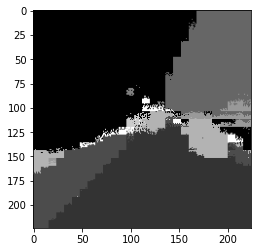

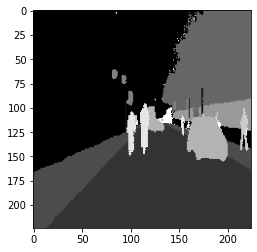

In [ ]:
pred = model.predict(tf.expand_dims(t[0], axis = 0))
pred = np.squeeze(pred)
pred = np.argmax(pred, axis = 2)
pred
plt.imshow(pred, cmap='gray')
plt.show()
plt.imshow(np.squeeze(t[1]), cmap = 'gray')

In [ ]:
tf.expand